In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pandas numpy matplotlib seaborn plotly scipy openpyxl

=== PHASE 1: LOADING AND EXPLORING EXCEL DATA ===
Main data shape: (300, 11)

First few rows of main data:
    Order ID       Date Destination Country          Region  Destination Zone  \
0  SOLE-0001 2024-12-08                India           Asia                65   
1  SOLE-0002 2024-11-27               France         Europe                56   
2  SOLE-0003 2024-03-08                  USA  North America                46   
3  SOLE-0004 2024-03-14                   UK         Europe                55   
4  SOLE-0005 2024-02-02                India           Asia                65   

       Carrier   Service  Weight (Kg)        Box Size  Product Price  \
0          UPS   Express         4.45  14.6X10.8X10.6            200   
1        FedEx  Standard         4.45  14.6X10.8X10.6            200   
2  Canada Post   Express         4.45  14.6X10.8X10.6            200   
3        FedEx  Standard         4.45  14.6X10.8X10.6            200   
4          UPS  Standard         4.45  14.6X10

/tmp/ipython-input-54920963.py:290: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-54920963.py:298: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Liberation Sans.
  plt.savefig('ab_test_dashboard.png', dpi=300, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


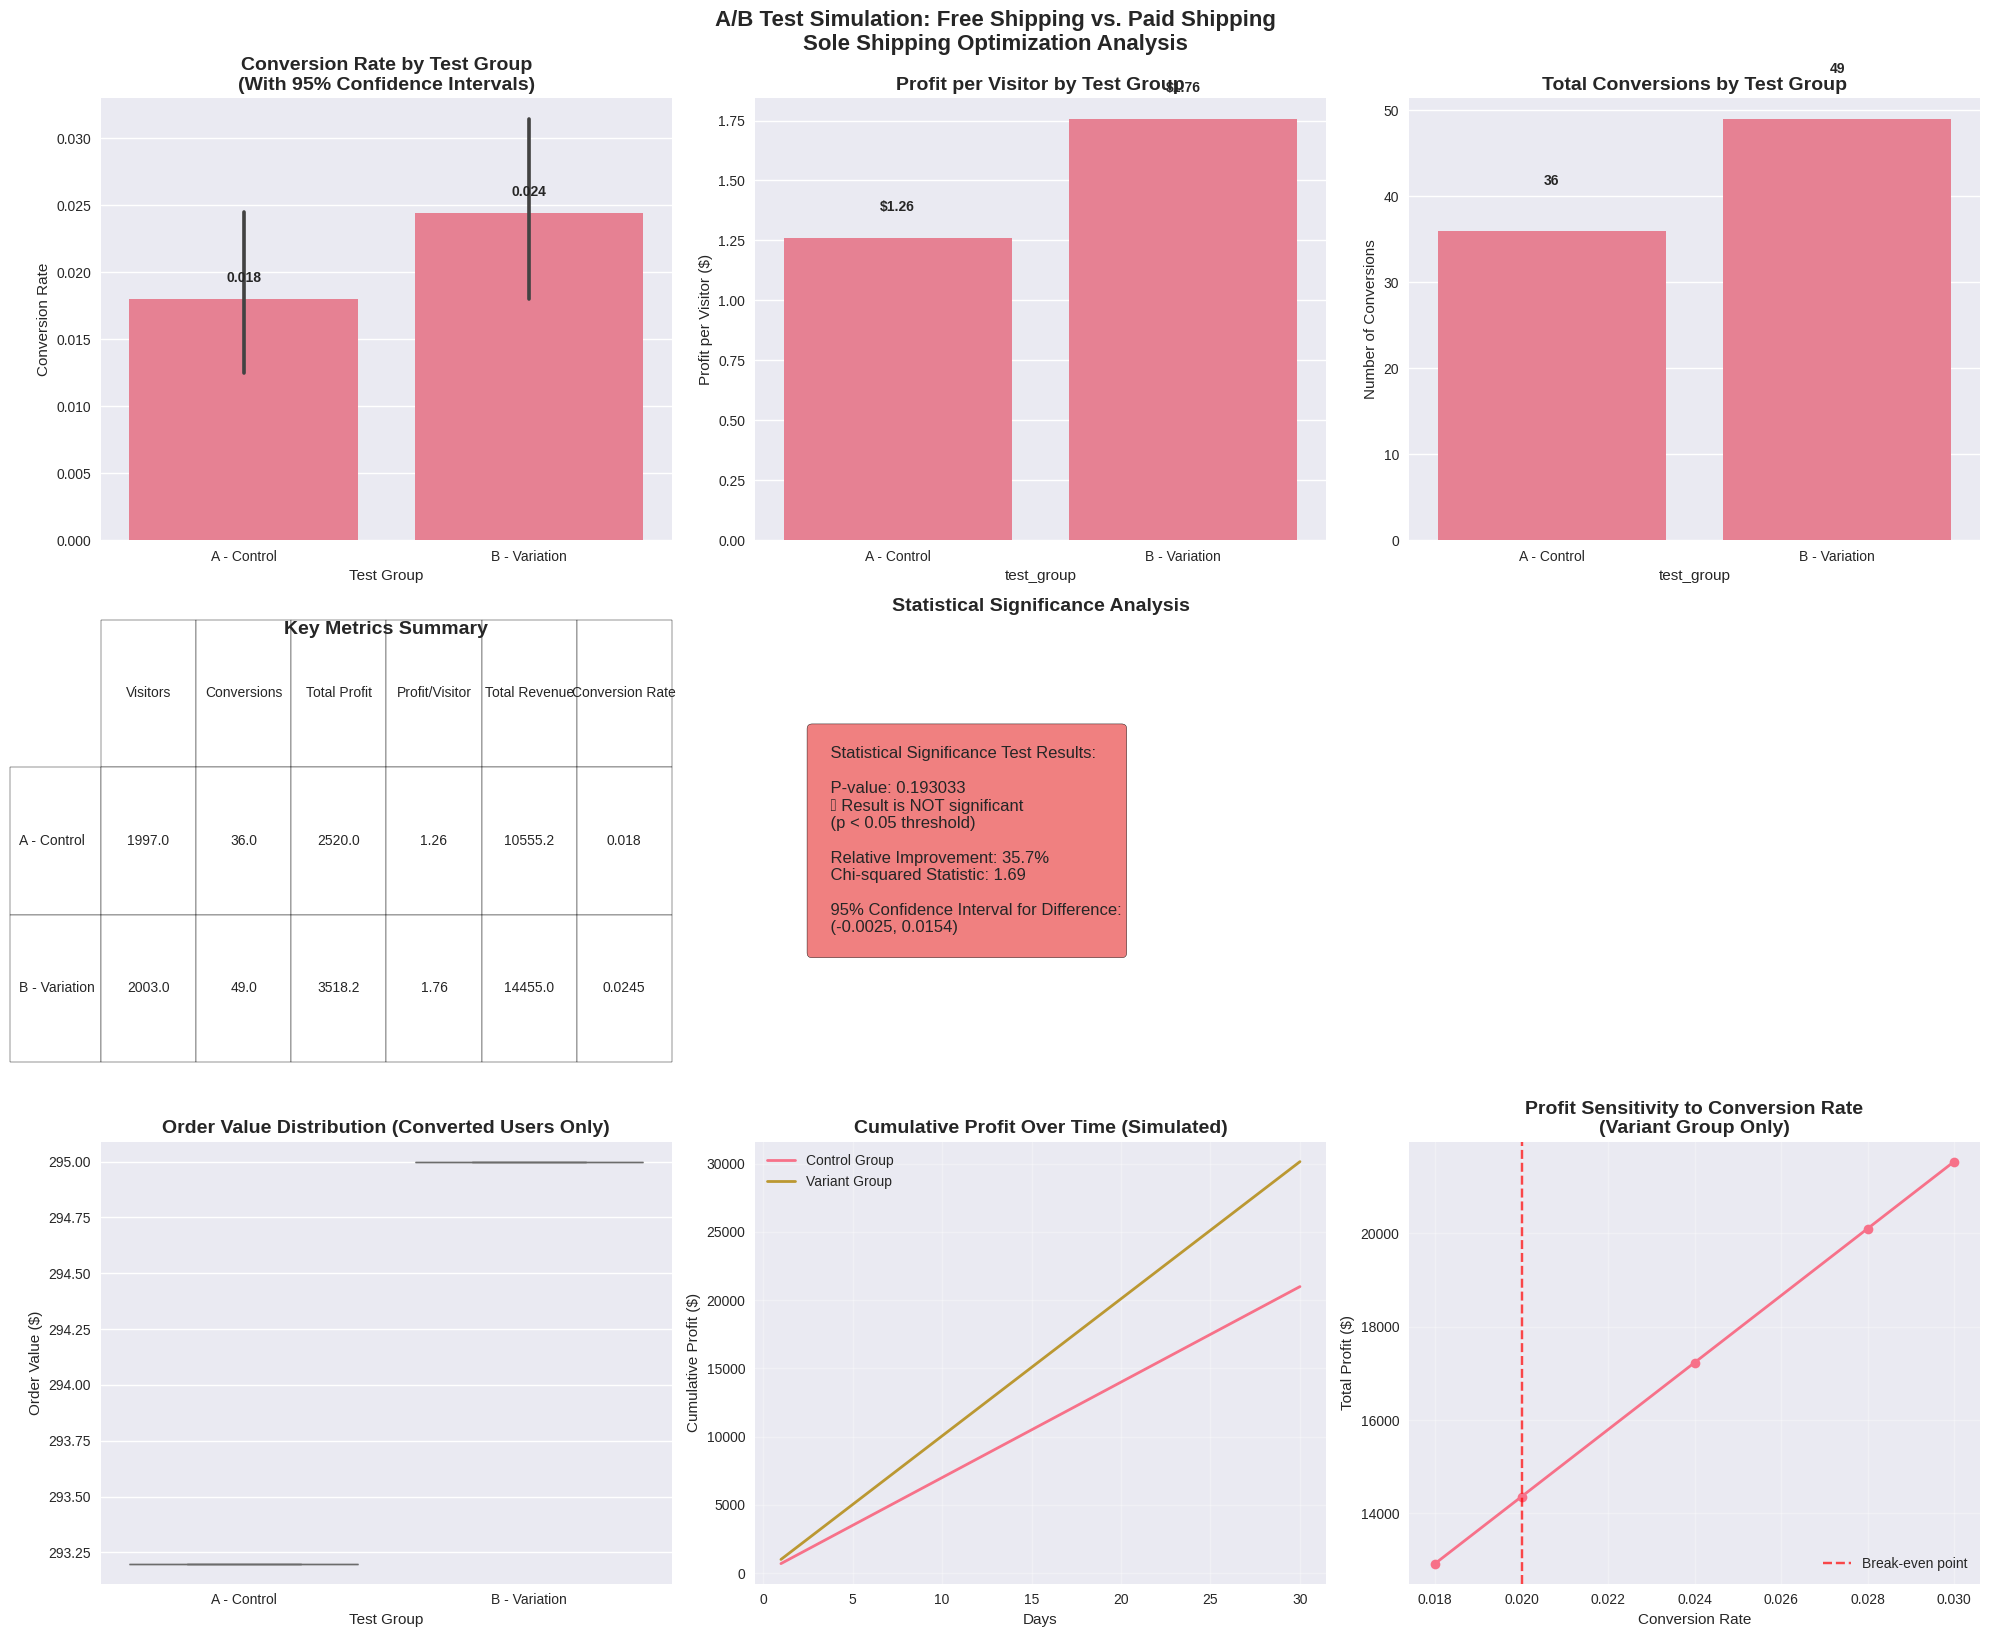


=== PHASE 6: SENSITIVITY ANALYSIS ===


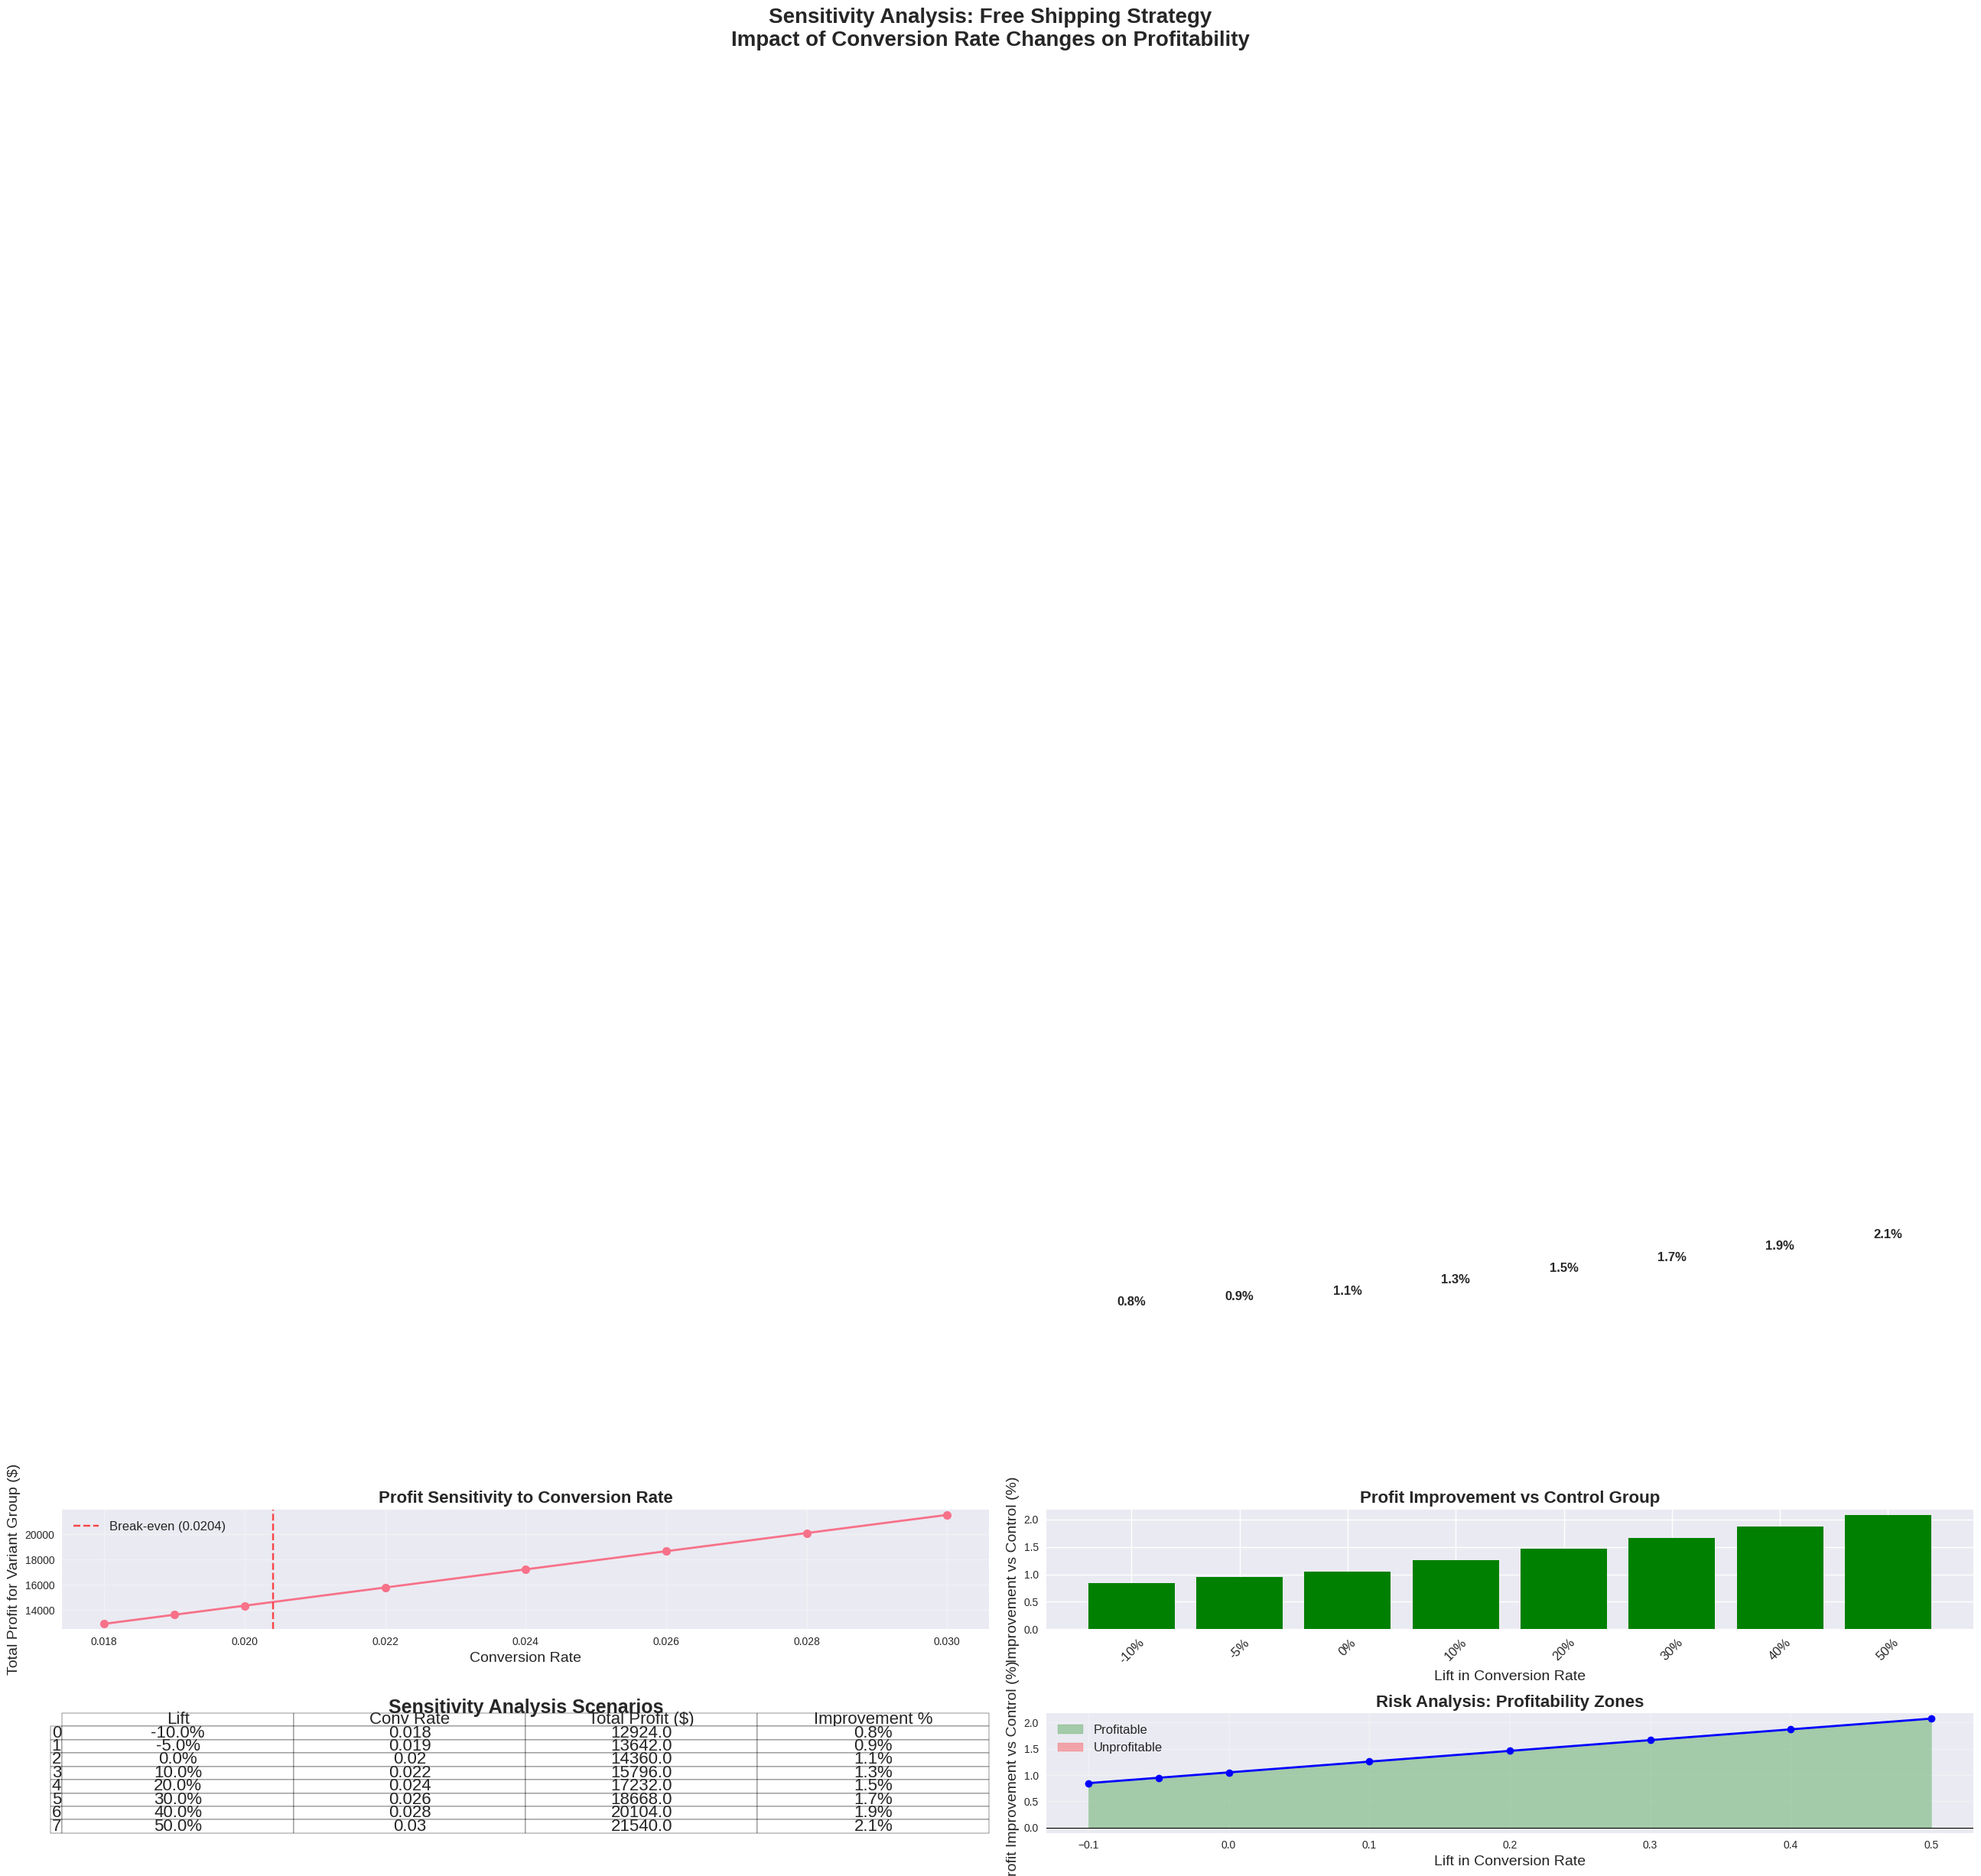


=== PHASE 7: SAVING RESULTS ===
Analysis complete! Files saved:
- ab_test_dashboard.png
- sensitivity_analysis_dashboard.png
- ab_test_simulation_results.csv
- sensitivity_analysis_results.csv
- analysis_summary.txt


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import warnings

# Function to handle FutureWarnings
def ignore_future_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

# Apply the warning filter
ignore_future_warnings()

# Set style for better visuals
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# 1. LOADING AND EXPLORING THE EXCEL DATA
print("=== PHASE 1: LOADING AND EXPLORING EXCEL DATA ===")

# Loading the main shipping data
df_main = pd.read_excel('/content/drive/MyDrive/Datasets/Sole Shipping Cost Analysis.xlsx', sheet_name='MainData')
print("Main data shape:", df_main.shape)
print("\nFirst few rows of main data:")
print(df_main.head())

# Basic exploration of main data
print("\n=== Basic Exploration ===")
print("Columns:", df_main.columns.tolist())
print("\nData types:")
print(df_main.dtypes)
print("\nBasic stats for numeric columns:")
print(df_main.describe())

# Checking for USA shipping costs specifically
usa_data = df_main[df_main['Destination Country '] == 'USA']
print(f"\nNumber of USA orders: {len(usa_data)}")
if len(usa_data) > 0:
    print("USA Shipping Cost stats:")
    print(usa_data['Shipping Cost'].describe())

# 2. SIMULATE A/B TEST DATA
print("\n=== PHASE 2: SIMULATING A/B TEST DATA ===")

def simulate_ab_test(n_visitors=4000, control_cr=0.02, variant_cr=0.028,
                    control_price=250, variant_price=295,
                    product_cost=180, shipping_cost=43.20):
    """
    Simulate A/B test data for free shipping experiment
    """
    np.random.seed(42)  # For reproducible results

    # Create visitors
    visitors = pd.DataFrame({
        'visitor_id': range(1, n_visitors + 1),
        'test_group': np.random.choice(['A - Control', 'B - Variation'],
                                      size=n_visitors, p=[0.5, 0.5])
    })

    # Simulate conversions based on group
    control_mask = visitors['test_group'] == 'A - Control'
    visitors['converted'] = False
    visitors.loc[control_mask, 'converted'] = np.random.random(sum(control_mask)) < control_cr
    visitors.loc[~control_mask, 'converted'] = np.random.random(sum(~control_mask)) < variant_cr

    # Calculate order values and profits
    visitors['order_value'] = 0
    visitors['profit'] = 0

    # Control group: pays product price + shipping
    control_converted = control_mask & visitors['converted']
    visitors.loc[control_converted, 'order_value'] = control_price + shipping_cost
    visitors.loc[control_converted, 'profit'] = control_price - product_cost

    # Variant group: pays higher price with "free" shipping
    variant_converted = ~control_mask & visitors['converted']
    visitors.loc[variant_converted, 'order_value'] = variant_price
    visitors.loc[variant_converted, 'profit'] = variant_price - product_cost - shipping_cost

    return visitors

# Generate the simulated data
ab_data = simulate_ab_test()
print("A/B Test simulation completed!")
print(f"Total visitors: {len(ab_data)}")
print(f"Control group size: {sum(ab_data['test_group'] == 'A - Control')}")
print(f"Variant group size: {sum(ab_data['test_group'] == 'B - Variation')}")

# 3. BASIC EXPLORATORY ANALYSIS
print("\n=== PHASE 3: EXPLORATORY ANALYSIS ===")

# Conversion rates by group
conversion_rates = ab_data.groupby('test_group')['converted'].agg(['sum', 'count', 'mean']).round(4)
conversion_rates.columns = ['conversions', 'visitors', 'conversion_rate']
print("Conversion rates by group:")
print(conversion_rates)

# Profit analysis
profit_summary = ab_data.groupby('test_group').agg({
    'profit': ['sum', 'mean'],
    'order_value': ['sum', 'mean'],
    'converted': 'sum'
}).round(2)
profit_summary.columns = ['total_profit', 'profit_per_visitor',
                         'total_revenue', 'avg_order_value', 'conversions']
print("\nProfit summary:")
print(profit_summary)

# 4. STATISTICAL SIGNIFICANCE TEST
print("\n=== PHASE 4: STATISTICAL SIGNIFICANCE ===")

def calculate_significance(ab_data):
    """Calculate chi-squared test for conversion rate significance"""
    # Create contingency table
    contingency_table = pd.crosstab(ab_data['test_group'], ab_data['converted'])

    # Chi-squared test
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

    # Calculate confidence intervals
    control_data = ab_data[ab_data['test_group'] == 'A - Control']
    variant_data = ab_data[ab_data['test_group'] == 'B - Variation']

    control_cr = control_data['converted'].mean()
    variant_cr = variant_data['converted'].mean()

    # Standard error for proportion
    n_control = len(control_data)
    n_variant = len(variant_data)

    se = np.sqrt(control_cr*(1-control_cr)/n_control + variant_cr*(1-variant_cr)/n_variant)
    margin_error = 1.96 * se  # 95% CI

    return {
        'p_value': p_value,
        'chi2_statistic': chi2,
        'relative_improvement': (variant_cr - control_cr) / control_cr,
        'confidence_interval': (variant_cr - control_cr - margin_error,
                              variant_cr - control_cr + margin_error),
        'is_significant': p_value < 0.05
    }

stats_results = calculate_significance(ab_data)
print("Statistical test results:")
for key, value in stats_results.items():
    print(f"{key}: {value}")

# 5. CREATE A/B TEST VISUALIZATION DASHBOARD
print("\n=== PHASE 5: CREATING VISUALIZATIONS ===")

def create_ab_test_dashboard(ab_data, stats_results):
    """Create comprehensive A/B test visualization dashboard"""

    fig = plt.figure(figsize=(20, 16))

    # 1. Conversion Rate Comparison (Top Left)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        plt.subplot(3, 3, 1)
        conversion_plot = sns.barplot(x='test_group', y='converted', data=ab_data, estimator=np.mean, ci=95)
        plt.title('Conversion Rate by Test Group\n(With 95% Confidence Intervals)', fontsize=14, fontweight='bold')
        plt.ylabel('Conversion Rate')
        plt.xlabel('Test Group')

        # Add conversion rate values on bars
        for i, p in enumerate(conversion_plot.patches):
            height = p.get_height()
            conversion_plot.text(p.get_x() + p.get_width()/2., height + 0.001,
                               f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

    # 2. Profit per Visitor (Top Middle)
    plt.subplot(3, 3, 2)
    profit_data = ab_data.groupby('test_group')['profit'].mean().reset_index()
    profit_plot = sns.barplot(x='test_group', y='profit', data=profit_data)
    plt.title('Profit per Visitor by Test Group', fontsize=14, fontweight='bold')
    plt.ylabel('Profit per Visitor ($)')

    for i, p in enumerate(profit_plot.patches):
        height = p.get_height()
        profit_plot.text(p.get_x() + p.get_width()/2., height + 0.1,
                       f'${height:.2f}', ha='center', va='bottom', fontweight='bold')

    # 3. Total Conversions (Top Right)
    plt.subplot(3, 3, 3)
    conversion_counts = ab_data.groupby('test_group')['converted'].sum().reset_index()
    count_plot = sns.barplot(x='test_group', y='converted', data=conversion_counts)
    plt.title('Total Conversions by Test Group', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Conversions')

    for i, p in enumerate(count_plot.patches):
        height = p.get_height()
        count_plot.text(p.get_x() + p.get_width()/2., height + 5,
                      f'{int(height)}', ha='center', va='bottom', fontweight='bold')

    # 4. Summary Statistics Table (Middle Left)
    plt.subplot(3, 3, 4)
    plt.axis('off')
    summary_data = ab_data.groupby('test_group').agg({
        'visitor_id': 'count',
        'converted': 'sum',
        'profit': ['sum', 'mean'],
        'order_value': 'sum'
    }).round(2)

    # Flatten column names
    summary_data.columns = ['Visitors', 'Conversions', 'Total Profit', 'Profit/Visitor', 'Total Revenue']
    summary_data['Conversion Rate'] = (summary_data['Conversions'] / summary_data['Visitors']).round(4)

    table = plt.table(cellText=summary_data.values,
                     rowLabels=summary_data.index,
                     colLabels=summary_data.columns,
                     cellLoc='center',
                     loc='center',
                     bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    plt.title('Key Metrics Summary', fontsize=14, fontweight='bold', y=0.95)

    # 5. Statistical Significance Summary (Middle Right)
    plt.subplot(3, 3, 5)
    plt.axis('off')

    sig_text = f"""
    Statistical Significance Test Results:

    P-value: {stats_results['p_value']:.6f}
    {'✓ Result is STATISTICALLY SIGNIFICANT' if stats_results['is_significant'] else '✗ Result is NOT significant'}
    (p < 0.05 threshold)

    Relative Improvement: {stats_results['relative_improvement']:.1%}
    Chi-squared Statistic: {stats_results['chi2_statistic']:.2f}

    95% Confidence Interval for Difference:
    ({stats_results['confidence_interval'][0]:.4f}, {stats_results['confidence_interval'][1]:.4f})
    """

    plt.text(0.1, 0.5, sig_text, fontsize=12, va='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue" if stats_results['is_significant'] else "lightcoral"))
    plt.title('Statistical Significance Analysis', fontsize=14, fontweight='bold')

    # 6. Revenue Distribution (Bottom Left)
    plt.subplot(3, 3, 7)
    revenue_data = ab_data[ab_data['converted'] == True]
    sns.boxplot(x='test_group', y='order_value', data=revenue_data)
    plt.title('Order Value Distribution (Converted Users Only)', fontsize=14, fontweight='bold')
    plt.ylabel('Order Value ($)')
    plt.xlabel('Test Group')

    # 7. Cumulative Profit Over Time Simulation (Bottom Middle)
    plt.subplot(3, 3, 8)

    # Simulate daily cumulative profit
    days = 30
    daily_visitors = 1000
    control_daily_profit = (daily_visitors * 0.5 * 0.02 * (250 - 180))
    variant_daily_profit = (daily_visitors * 0.5 * 0.028 * (295 - 180 - 43.20))

    days_range = range(1, days + 1)
    control_cumulative = [control_daily_profit * day for day in days_range]
    variant_cumulative = [variant_daily_profit * day for day in days_range]

    plt.plot(days_range, control_cumulative, label='Control Group', linewidth=2)
    plt.plot(days_range, variant_cumulative, label='Variant Group', linewidth=2)
    plt.title('Cumulative Profit Over Time (Simulated)', fontsize=14, fontweight='bold')
    plt.xlabel('Days')
    plt.ylabel('Cumulative Profit ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 8. Sensitivity Analysis Preview (Bottom Right)
    plt.subplot(3, 3, 9)

    # Different conversion rate scenarios
    cr_scenarios = [0.018, 0.020, 0.024, 0.028, 0.030]
    profits = [10000 * cr * (295 - 180 - 43.20) for cr in cr_scenarios]

    plt.plot(cr_scenarios, profits, marker='o', linewidth=2)
    plt.axvline(x=0.02, color='red', linestyle='--', alpha=0.7, label='Break-even point')
    plt.title('Profit Sensitivity to Conversion Rate\n(Variant Group Only)', fontsize=14, fontweight='bold')
    plt.xlabel('Conversion Rate')
    plt.ylabel('Total Profit ($)')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.suptitle('A/B Test Simulation: Free Shipping vs. Paid Shipping\nSole Shipping Optimization Analysis',
                 fontsize=16, fontweight='bold', y=1.02)

    return fig

# Generate the dashboard
ab_dashboard = create_ab_test_dashboard(ab_data, stats_results)
plt.savefig('ab_test_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. SENSITIVITY ANALYSIS DASHBOARD
print("\n=== PHASE 6: SENSITIVITY ANALYSIS ===")

def create_sensitivity_dashboard():
    """Create sensitivity analysis dashboard"""

    # Define scenarios
    lifts = [-0.10, -0.05, 0.00, 0.10, 0.20, 0.30, 0.40, 0.50]
    base_cr = 0.02
    scenarios = [base_cr * (1 + lift) for lift in lifts]

    # Calculate metrics for each scenario
    sensitivity_data = []
    for cr in scenarios:
        control_profit = 10000 * 0.5 * 0.02 * (250 - 180)  # Fixed control
        variant_profit = 10000 * 0.5 * cr * (295 - 180 - 43.20)
        total_profit_variant = variant_profit * 2  # For 10k visitors in variant group

        sensitivity_data.append({
            'lift': (cr - base_cr) / base_cr,
            'conversion_rate': cr,
            'variant_profit_per_visitor': variant_profit / (10000 * 0.5),
            'total_profit_variant': total_profit_variant,
            'improvement_vs_control': (variant_profit - (control_profit / 2)) / (control_profit / 2)  # Per group basis
        })

    sensitivity_df = pd.DataFrame(sensitivity_data)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(26, 24)) # Adjusted figure size again

    # 1. Profit vs Conversion Rate
    ax1.plot(sensitivity_df['conversion_rate'], sensitivity_df['total_profit_variant'],
             marker='o', linewidth=2, markersize=8)
    ax1.axvline(x=0.0204, color='red', linestyle='--', alpha=0.7, label='Break-even (0.0204)')
    ax1.set_xlabel('Conversion Rate', fontsize=14)
    ax1.set_ylabel('Total Profit for Variant Group ($)', fontsize=14)
    ax1.set_title('Profit Sensitivity to Conversion Rate', fontweight='bold', fontsize=16)
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=12)

    # 2. Improvement vs Control
    ax2.bar([f'{lift:.0%}' for lift in sensitivity_df['lift']],
            sensitivity_df['improvement_vs_control'],
            color=['red' if x < 0 else 'green' for x in sensitivity_df['improvement_vs_control']])
    ax2.set_xlabel('Lift in Conversion Rate', fontsize=14)
    ax2.set_ylabel('Improvement vs Control (%)', fontsize=14)
    ax2.set_title('Profit Improvement vs Control Group', fontweight='bold', fontsize=16)
    ax2.tick_params(axis='x', rotation=45, labelsize=12)

    # Add value labels on bars
    for i, v in enumerate(sensitivity_df['improvement_vs_control']):
        ax2.text(i, v + (5 if v > 0 else -10), f'{v:.1f}%',
                ha='center', va='bottom' if v > 0 else 'top', fontweight='bold', fontsize=12)

    # 3. Sensitivity Table
    ax3.axis('off')
    table_data = sensitivity_df[['lift', 'conversion_rate', 'total_profit_variant', 'improvement_vs_control']].round(4)
    table_data.columns = ['Lift', 'Conv Rate', 'Total Profit ($)', 'Improvement %']
    table_data['Lift'] = table_data['Lift'].apply(lambda x: f'{x:.1%}')
    table_data['Improvement %'] = table_data['Improvement %'].apply(lambda x: f'{x:.1f}%')

    table = ax3.table(cellText=table_data.values,
                     rowLabels=table_data.index,
                     colLabels=table_data.columns,
                     cellLoc='center',
                     loc='center',
                     bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(16)
    table.scale(2.5, 3.0)
    ax3.set_title('Sensitivity Analysis Scenarios', fontweight='bold', y=0.95, fontsize=18)

    # 4. Risk Analysis
    ax4.axhline(y=0, color='black', linewidth=0.8)
    ax4.fill_between(sensitivity_df['lift'], 0, sensitivity_df['improvement_vs_control'],
                    where=sensitivity_df['improvement_vs_control'] >= 0,
                    color='green', alpha=0.3, label='Profitable')
    ax4.fill_between(sensitivity_df['lift'], 0, sensitivity_df['improvement_vs_control'],
                    where=sensitivity_df['improvement_vs_control'] < 0,
                    color='red', alpha=0.3, label='Unprofitable')
    ax4.plot(sensitivity_df['lift'], sensitivity_df['improvement_vs_control'],
            marker='o', linewidth=2, color='blue')
    ax4.set_xlabel('Lift in Conversion Rate', fontsize=14)
    ax4.set_ylabel('Profit Improvement vs Control (%)', fontsize=14)
    ax4.set_title('Risk Analysis: Profitability Zones', fontweight='bold', fontsize=16)
    ax4.legend(fontsize=12)
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle('Sensitivity Analysis: Free Shipping Strategy\nImpact of Conversion Rate Changes on Profitability',
                 fontsize=20, fontweight='bold', y=1.02)

    return fig, sensitivity_df

# Generate sensitivity dashboard
sensitivity_dashboard, sensitivity_results = create_sensitivity_dashboard()
plt.savefig('sensitivity_analysis_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

# 7. SAVE RESULTS
print("\n=== PHASE 7: SAVING RESULTS ===")

# Save simulated data
ab_data.to_csv('ab_test_simulation_results.csv', index=False)
sensitivity_results.to_csv('sensitivity_analysis_results.csv', index=False)

# Save summary statistics
with open('analysis_summary.txt', 'w') as f:
    f.write("SOLE CAPSULE A/B TEST ANALYSIS SUMMARY\n")
    f.write("="*50 + "\n\n")
    f.write(f"Control Conversion Rate: {conversion_rates.loc['A - Control', 'conversion_rate']:.3f}\n")
    f.write(f"Variant Conversion Rate: {conversion_rates.loc['B - Variation', 'conversion_rate']:.3f}\n")
    f.write(f"Relative Improvement: {stats_results['relative_improvement']:.1%}\n")
    f.write(f"Statistical Significance: {'YES' if stats_results['is_significant'] else 'NO'} (p-value: {stats_results['p_value']:.6f})\n")
    f.write(f"Recommended Action: {'IMPLEMENT Variant B' if stats_results['is_significant'] else 'KEEP Control Group'}\n")

print("Analysis complete! Files saved:")
print("- ab_test_dashboard.png")
print("- sensitivity_analysis_dashboard.png")
print("- ab_test_simulation_results.csv")
print("- sensitivity_analysis_results.csv")
print("- analysis_summary.txt")

In [4]:
from nbconvert import HTMLExporter
import nbformat

# Load the notebook
notebook_path = "/content/drive/MyDrive/Datasets/Sole Shipping.ipynb"
output_html_path = "/content/drive/MyDrive/Datasets/Sole Shipping.html"

with open(notebook_path, 'r', encoding='utf-8') as f:
    notebook_content = nbformat.read(f, as_version=4)

# Convert to HTML
html_exporter = HTMLExporter()
(body, resources) = html_exporter.from_notebook_node(notebook_content)

# save to HTML file
with open(output_html_path, 'w', encoding='utf-8') as f:
    f.write(body.replace(u'\u00A0', ' '))